# Treci domaci zadatak iz predmeta masinsko ucenje

## Dragana Ninkovic 2023/3010

## Unos podataka i predprocesiranje

In [1]:
# Import libararies
import numpy as np;
import matplotlib.pyplot as plt;
import cvxopt

In [18]:
# Read data
data = np.loadtxt("C:/Users/Dragana/Downloads/mu-d3/svmData.csv", delimiter = ',');

In [19]:
#
seed_value = 30
np.random.seed(seed_value)
np.random.shuffle(data)
print(data.shape)

(100, 3)


In [20]:
# Split on features and labels
X = data[:,0:2];
y = data[:,2];

In [21]:
# Train test split
train_size = int(0.8*X.shape[0]);
X_train = X[0:train_size,:];
y_train = y[0:train_size];
X_test = X[train_size:,:];
y_test = y[train_size:];

In [22]:
# Calculate standardization parameters on training set
X_mean = np.mean(X_train, axis = 0);
X_std = np.std(X_train, axis = 0);

X_train_norm = (X_train - X_mean)/X_std;
X_test_norm = (X_test - X_mean)/X_std;

Text(0.5, 1.0, 'Training data plot')

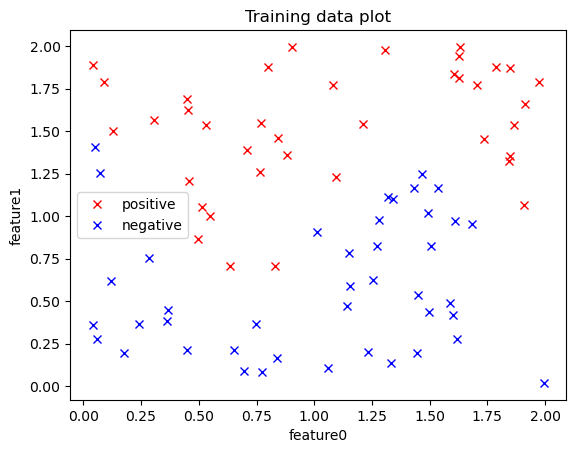

In [23]:
# Plot training data
plt.figure()
plt.plot(X_train[y_train == 1,0],X_train[y_train == 1,1], 'rx')
plt.plot(X_train[y_train == -1,0],X_train[y_train == -1,1], 'bx')
plt.legend(['positive', 'negative']);
plt.xlabel('feature0')
plt.ylabel('feature1');
plt.title('Training data plot')

Mozemo videti da ulazne podatke nije moguce odvojiti linearnom granicom i da ocekujemo da ce linearni klasifikator imati vecu gresku od nelinearnog. Takodje, samim tim je neophodno koristiti dozvole ulaska u losu oblast. S druge strane, podaci su dovoljno separabilni da bi trebalo da mogu da se odvoje nekim nelinearnim klasifikatorom ne prevelikog reda.

## Unakrsna validacija

Za pronalazenje hiper parametara koriscena je ista funkcija za unaksnu validaciju kao u prvom domacem zadatku.

In [24]:
# Cross validation function for linear SVM
def cross_validation(X,y,num_folds,fold_size,C_values):
    validation_loss_mean = []
    validation_loss_std = []
    train_loss_mean = []
    train_loss_std = []
    
    for C in C_values:
        current_train_loss = []
        current_validation_loss = []
        
        for fold in range(num_folds):
            # Split data into training and validation set
            start = fold * fold_size
            end = (fold + 1) * fold_size
            
            X_validation = X[start:end]
            y_validation = y[start:end].reshape(X_validation.shape[0],1)
            
            X_train = np.concatenate((X[:start], X[end:]), axis=0)
            y_train = np.concatenate((y[:start], y[end:])).reshape(X_train.shape[0],1)
            
            # Calculate statistic of X_train
            X_mean = np.mean(X_train, axis = 0).reshape(1,X_train.shape[1])
            X_std = np.std(X_train, axis = 0).reshape(1,X_train.shape[1])
            
            # Standardization
            X_train = (X_train - X_mean)/X_std           
            X_validation = (X_validation - X_mean)/X_std

            solution = SVM_primal(X_train, y_train,C);
            
            b = np.array(solution[0]);
            w = np.array(solution[1:3]);
            psi = np.array(solution[3:]);
            
            y_validation_pred = linear_predict(X_validation,w,b);
            y_train_pred = linear_predict(X_train,w,b);
            
            # Keep loss results 
            current_validation_loss.append(hinge_loss(y_validation_pred,y_validation))
            current_train_loss.append(hinge_loss(y_train_pred,y_train))
            
            
        # Keep statistics of loss results for this iteration
        validation_loss_mean.append(np.mean(current_validation_loss))
        validation_loss_std.append(np.std(current_validation_loss))
        train_loss_mean.append(np.mean(current_train_loss))
        train_loss_std.append(np.std(current_train_loss))
        
    # Convert lists to numpy arrays    
    validation_loss_mean = np.array(validation_loss_mean)
    validation_loss_std = np.array(validation_loss_std)
    train_loss_mean = np.array(train_loss_mean)
    train_loss_std = np.array(train_loss_std)
    
    return (validation_loss_mean,validation_loss_std,train_loss_mean,train_loss_std)

## Primalni problem i linearan kernel

Funkcija cvxopt za kvadratno programiranje prihvata jednacine u sledecoj formi: $$ min (\frac{1}{2}x^TPx+q^Tx)$$
$$ Gx \preceq h$$ $$ Ax = b\\$$ 
, a nas vektor parametara je $$ \begin{bmatrix} b\\ w_0\\ w_1\\ \psi_1\\ ... \\ \psi_m\\ \end{bmatrix}$$

### 1. Racunanje matrica P i q: 

Nasa kriterijmska funkcija je $$min(\frac{1}{2} ||w||^2+\sum_1^m \psi_i)$$. Kako u kvadratnom delu ucestvuje samo vektor w, matrica P ce biti kvadratna matrica ciji su svi elementi nula sem elemenata na dijagonali koji odgovaraju $w_0$ i$ w_1$. U linearnom clanu ucestvuju samo parametri $\psi_i$ pa ce q biti vektor cija su prva tri elementa nula i ostalo jedinice.

### 2. Racunanje matrica G i h: 

Uslovi pod kojima racunamo kriterijum su da je $1-\hat{\gamma}^{(i)} - \psi_i\leq 0$ tj. da je $-y^{(i)}w^T(x^{(i)})^T-y^{(i)}b - \psi_i \leq -1$ i da su svi $\psi_i$ pozitivni. Iz ovoga zakljucujemo da ce prvih m redova matrice G koji odgovaraju prvih m nejednakosti imati vektor -y kao prvu kolonu vektor $-y.T*X$ kao druge dve kolone i negiranu jedinicnu matricu kao ostale elemente. Poslednjih m redova matrice G ce ciniti matrica koja ima tri reda jednaka nuli a zatim negiranu jedinicnu matricu. Matrica h kao prvih m elemenata ima -1 a poslednjih m 0.

### 3. Racunanje matrica A i b

S obzirom da nemamo uslove tipa jednakosti ove dve matrice nam nisu potrebne.

In [25]:
# Implementing SVM for primal problem 
def SVM_primal(X,y,C):
    n_samples, n_features = X.shape
    P = np.zeros((3+n_samples, 3+n_samples));
    
    P[1,1] = 1;
    P[2,2] = 1;
    P = cvxopt.matrix(P);

    q = np.ones((n_samples+3,1))*C
    q[0:3] = 0;
    q = cvxopt.matrix(q);

    G_high = np.concatenate((y,y*X, np.eye(n_samples)), axis = 1);
    G_low = np.concatenate((np.zeros((n_samples,3)), np.eye(n_samples)), axis = 1);
    G = np.concatenate((G_high, G_low), axis = 0)
    G = cvxopt.matrix(-G);

    h_high = np.ones((n_samples,1))*-1
    h_low = np.zeros((n_samples,1))
    h = np.concatenate((h_high,h_low),axis = 0);
    h = cvxopt.matrix(h);

    return  cvxopt.solvers.qp(P, q, G, h)['x']

Za funkciju gubitka koristi se Hinge loss koji je jednak $max(1- \hat{\gamma},0)$ u slucaju linearnog klasifikatora, u slucaju nelinearnog klasifikatora mozemo oduzeti od 1 umnozak prave i prediktovane vrednosti.

In [26]:
# Hinge loss function
def linear_predict(x,w,b):
    return (x@w+b);
def hinge_loss(y_pred, y):
    gamma_hat_i = y*y_pred
    loss = 1-gamma_hat_i;
    loss[loss<0] = 0;  
    return  np.sum(loss)/len(y)

### Biranje hiperparametra C

In [27]:
n_samples, n_features = X_train.shape
num_folds = 5
fold_size = n_samples // num_folds
C = [0.001,0.002,0.005,0.008,0.01,0.02,0.05,0.08,0.1,0.2,0.5,0.8,1,2,5,8,10,20,50,80, 100,200,500,800, 1000]
y_train = y_train.reshape(n_samples,1)
(validation_rmse_mean,validation_rmse_std,train_rmse_mean,train_rmse_std) = cross_validation(X_train, y_train, num_folds, fold_size, C)

     pcost       dcost       gap    pres   dres
 0:  3.1490e-01  1.2612e+01  4e+02  3e+00  1e+02
 1:  3.9303e-01 -8.7197e+00  9e+00  6e-02  2e+00
 2:  1.6226e-01 -5.7784e-01  7e-01  4e-03  2e-01
 3:  1.2833e-01  5.2997e-02  8e-02  7e-16  2e-17
 4:  6.4173e-02  5.6379e-02  8e-03  4e-16  1e-17
 5:  5.8028e-02  5.6813e-02  1e-03  3e-16  4e-17
 6:  5.7982e-02  5.6941e-02  1e-03  3e-16  4e-17
 7:  5.7288e-02  5.7103e-02  2e-04  2e-16  3e-17
 8:  5.7188e-02  5.7159e-02  3e-05  3e-16  1e-17
 9:  5.7173e-02  5.7169e-02  4e-06  3e-16  3e-17
10:  5.7171e-02  5.7171e-02  7e-08  3e-16  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.9682e-01  1.3487e+01  4e+02  3e+00  9e+01
 1:  3.7573e-01 -7.5634e+00  8e+00  5e-02  2e+00
 2:  1.5697e-01 -4.6072e-01  6e-01  4e-03  1e-01
 3:  1.2250e-01  5.4245e-02  7e-02  6e-16  6e-17
 4:  6.4849e-02  5.8380e-02  6e-03  4e-16  1e-17
 5:  5.9672e-02  5.8808e-02  9e-04  3e-16  5e-17
 6:  5.9657e-02  5.8942e-02  7e-04  3e-16  1e-1

 1:  2.0981e+01 -8.5214e+00  3e+01  1e-01  2e+00
 2:  6.5086e+00  3.6739e+00  3e+00  5e-16  7e-16
 3:  5.0919e+00  4.4768e+00  6e-01  3e-16  4e-16
 4:  4.8524e+00  4.6925e+00  2e-01  3e-16  6e-16
 5:  4.7818e+00  4.7532e+00  3e-02  2e-16  1e-14
 6:  4.7677e+00  4.7662e+00  1e-03  3e-16  2e-14
 7:  4.7670e+00  4.7670e+00  2e-05  2e-16  2e-14
 8:  4.7670e+00  4.7670e+00  2e-07  3e-16  3e-14
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  8.9927e-01  3.6443e+01  4e+02  3e+00  6e+01
 1:  2.1369e+01 -6.6748e+00  3e+01  9e-02  2e+00
 2:  6.2494e+00  3.9721e+00  2e+00  5e-16  9e-16
 3:  5.2254e+00  4.7787e+00  4e-01  3e-16  5e-16
 4:  5.0575e+00  4.9314e+00  1e-01  2e-16  4e-15
 5:  5.0099e+00  4.9799e+00  3e-02  2e-16  2e-14
 6:  4.9985e+00  4.9916e+00  7e-03  2e-16  1e-14
 7:  4.9953e+00  4.9951e+00  2e-04  3e-16  1e-14
 8:  4.9952e+00  4.9952e+00  2e-06  2e-16  3e-14
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -5.7325e+00  7.3867

12:  9.1389e+02  9.1389e+02  3e-04  5e-16  2e-14
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -3.2477e+05  1.1703e+05  4e+05  1e+02  2e+00
 1:  2.8950e+04 -2.2786e+03  3e+04  6e-01  8e-03
 2:  3.4367e+03  8.1092e+02  3e+03  3e-02  4e-04
 3:  1.8953e+03  1.0436e+03  9e+02  7e-03  9e-05
 4:  1.8088e+03  1.1367e+03  7e+02  5e-03  6e-05
 5:  1.7298e+03  1.2099e+03  5e+02  3e-03  4e-05
 6:  1.5712e+03  1.2633e+03  3e+02  8e-04  1e-05
 7:  1.4829e+03  1.3203e+03  2e+02  4e-04  5e-06
 8:  1.4255e+03  1.3559e+03  7e+01  1e-04  1e-06
 9:  1.3905e+03  1.3843e+03  6e+00  5e-06  6e-08
10:  1.3872e+03  1.3869e+03  3e-01  2e-07  3e-09
11:  1.3870e+03  1.3870e+03  3e-03  2e-09  3e-11
12:  1.3870e+03  1.3870e+03  3e-05  2e-11  3e-13
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -3.1933e+05  4.7592e+04  2e+05  1e+02  8e-01
 1: -7.7871e+03 -9.6252e+02  2e+04  7e+00  4e-02
 2:  1.2339e+03  1.0440e+03  2e+03  5e-01  3e-03
 3:  1.6886e+03  1.3532

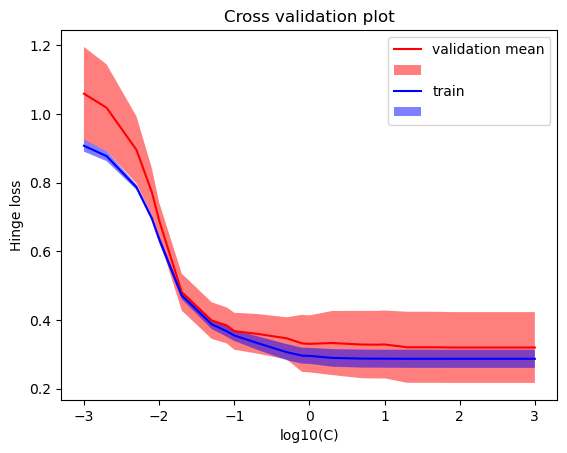

In [28]:
plt.figure()
plt.plot(np.log10(C),validation_rmse_mean,c='r')
plt.fill_between(np.log10(C),validation_rmse_mean-validation_rmse_std,validation_rmse_mean+validation_rmse_std, facecolor='red', alpha=0.5)
plt.plot(np.log10(C),train_rmse_mean, c= 'b')
plt.fill_between(np.log10(C),train_rmse_mean-train_rmse_std,train_rmse_mean+train_rmse_std, facecolor='blue', alpha=0.5)
plt.xlabel('log10(C)')
plt.ylabel('Hinge loss')
plt.legend(['validation mean', '','train',''])
plt.title("Cross validation plot")
plt.show()

Mozemo primetiti da i validaciona i obucavajuca kriva dostizu minimum na opsegu 1 do 100. Ovaj opseg je dodatno posmatran u cilju odredjivanja tacnog parametra C

In [32]:
C = list(np.linspace(1,100,num = 20))

(validation_rmse_mean,validation_rmse_std,train_rmse_mean,train_rmse_std) = cross_validation(X_train, y_train, num_folds, fold_size, C)

     pcost       dcost       gap    pres   dres
 0: -3.7223e+01  1.2934e+02  6e+02  4e+00  1e+01
 1:  6.3719e+01 -1.0401e+01  1e+02  4e-01  1e+00
 2:  2.4982e+01  1.4480e+01  1e+01  4e-02  1e-01
 3:  2.0938e+01  1.8358e+01  3e+00  7e-03  2e-02
 4:  2.0124e+01  1.9477e+01  7e-01  1e-03  4e-03
 5:  1.9843e+01  1.9734e+01  1e-01  4e-16  1e-14
 6:  1.9793e+01  1.9786e+01  7e-03  4e-16  2e-15
 7:  1.9789e+01  1.9789e+01  8e-05  4e-16  8e-15
 8:  1.9789e+01  1.9789e+01  8e-07  4e-16  4e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -3.5582e+01  1.2437e+02  5e+02  4e+00  1e+01
 1:  6.5373e+01  5.3668e+00  7e+01  2e-01  5e-01
 2:  2.8018e+01  1.8518e+01  1e+01  3e-02  7e-02
 3:  2.4120e+01  2.1607e+01  3e+00  6e-03  2e-02
 4:  2.3162e+01  2.2561e+01  7e-01  1e-03  3e-03
 5:  2.2858e+01  2.2814e+01  5e-02  8e-05  2e-04
 6:  2.2835e+01  2.2835e+01  5e-04  8e-07  2e-06
 7:  2.2835e+01  2.2835e+01  5e-06  8e-09  2e-08
Optimal solution found.
     pcost       dcost 

13:  7.4151e+02  7.4151e+02  7e-04  5e-16  8e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -9.0624e+04  1.5225e+04  6e+04  7e+01  8e-01
 1: -1.6848e+03 -8.8242e+01  6e+03  4e+00  5e-02
 2:  6.3390e+02  5.8352e+02  7e+02  4e-01  4e-03
 3:  8.2987e+02  6.8747e+02  6e+02  2e-01  3e-03
 4:  9.1307e+02  7.4484e+02  5e+02  1e-01  2e-03
 5:  9.1291e+02  8.1292e+02  2e+02  6e-02  7e-04
 6:  9.4993e+02  8.3053e+02  1e+02  2e-02  2e-04
 7:  9.2797e+02  8.6594e+02  7e+01  6e-03  7e-05
 8:  9.1181e+02  8.8054e+02  3e+01  2e-03  2e-05
 9:  8.9667e+02  8.9476e+02  2e+00  8e-05  1e-06
10:  8.9565e+02  8.9561e+02  4e-02  2e-06  2e-08
11:  8.9563e+02  8.9563e+02  4e-04  2e-08  2e-10
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -9.2024e+04  2.7282e+04  9e+04  7e+01  2e+00
 1:  3.7886e+03 -6.3622e+02  9e+03  2e+00  5e-02
 2:  1.1601e+03  4.8315e+02  1e+03  2e-01  4e-03
 3:  1.1217e+03  6.4797e+02  6e+02  8e-02  2e-03
 4:  1.0115e+03  7.1519

 8:  1.5155e+03  1.4202e+03  1e+02  2e-04  2e-06
 9:  1.4679e+03  1.4585e+03  9e+00  5e-16  6e-16
10:  1.4629e+03  1.4624e+03  4e-01  5e-16  3e-15
11:  1.4626e+03  1.4626e+03  5e-03  5e-16  5e-14
12:  1.4626e+03  1.4626e+03  5e-05  5e-16  4e-14
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -3.5523e+05  5.2544e+04  2e+05  1e+02  8e-01
 1: -8.7965e+03 -1.1134e+03  2e+04  8e+00  4e-02
 2:  1.3148e+03  1.0973e+03  2e+03  5e-01  3e-03
 3:  1.7797e+03  1.4257e+03  1e+03  2e-01  9e-04
 4:  1.8681e+03  1.4882e+03  8e+02  1e-01  6e-04
 5:  1.8281e+03  1.6258e+03  4e+02  4e-02  2e-04
 6:  1.8732e+03  1.6543e+03  3e+02  1e-02  6e-05
 7:  1.8295e+03  1.7157e+03  1e+02  4e-03  2e-05
 8:  1.7998e+03  1.7389e+03  7e+01  1e-03  7e-06
 9:  1.7696e+03  1.7664e+03  3e+00  5e-05  3e-07
10:  1.7678e+03  1.7678e+03  5e-02  7e-07  4e-09
11:  1.7678e+03  1.7678e+03  5e-04  7e-09  4e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -3.6063e+05  9.9181

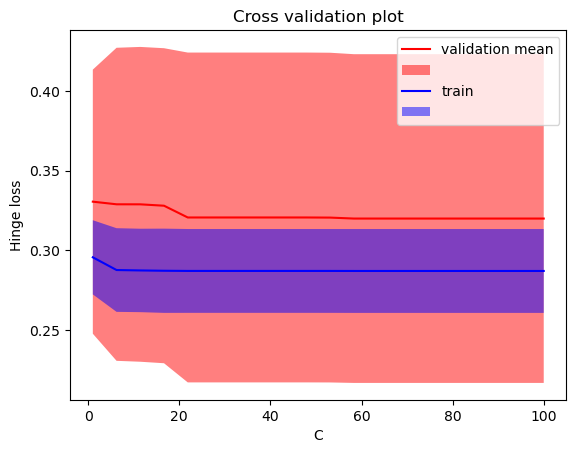

In [34]:
plt.figure()
plt.plot(C,validation_rmse_mean,c='r')
plt.fill_between(C,validation_rmse_mean-validation_rmse_std,validation_rmse_mean+validation_rmse_std, facecolor='red', alpha=0.5)
plt.plot(C,train_rmse_mean, c= 'b')
plt.fill_between(C,train_rmse_mean-train_rmse_std,train_rmse_mean+train_rmse_std, facecolor='blue', alpha=0.5)
plt.legend(['validation mean', '','train',''])
plt.xlabel('C')
plt.ylabel('Hinge loss')
plt.title("Cross validation plot")
plt.show()

In [77]:
C_opt = 20
solution = SVM_primal(X_train_norm, y_train,C_opt);

b = np.array(solution[0,0]).reshape(1,1);
w = np.array(solution[1:3,0]).reshape(2,1);
psi = np.array(solution[3:]);
 

     pcost       dcost       gap    pres   dres
 0: -2.5189e+04  9.8239e+03  3e+04  4e+01  2e+00
 1:  2.5371e+03  7.7067e+01  3e+03  2e-01  1e-02
 2:  7.0587e+02  3.0724e+02  4e+02  3e-02  2e-03
 3:  6.0259e+02  3.8628e+02  2e+02  1e-02  6e-04
 4:  5.2354e+02  4.2158e+02  1e+02  4e-03  2e-04
 5:  4.9732e+02  4.4618e+02  5e+01  1e-03  8e-05
 6:  4.8471e+02  4.5394e+02  3e+01  4e-04  2e-05
 7:  4.6888e+02  4.6693e+02  2e+00  9e-06  5e-07
 8:  4.6778e+02  4.6773e+02  5e-02  2e-07  1e-08
 9:  4.6775e+02  4.6775e+02  5e-04  2e-09  1e-10
10:  4.6775e+02  4.6775e+02  5e-06  2e-11  1e-12
Optimal solution found.


Text(0.5, 1.0, 'Classification')

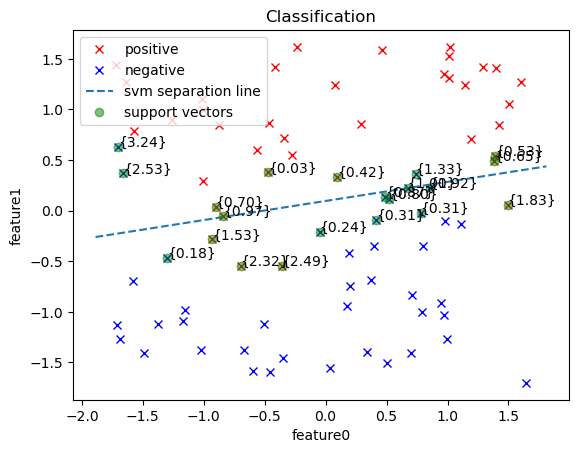

In [85]:
plt.figure()
label_1 = ((y_train == 1).T)[0]
label_minus_1 = ((y_train == -1).T)[0]
plt.plot(X_train_norm[label_1,0],X_train_norm[label_1,1], 'rx')
plt.plot(X_train_norm[label_minus_1,0],X_train_norm[label_minus_1,1], 'bx')
xl, xr = plt.xlim()
x_axis = np.array([xl, xr]).reshape(2,1)
y_svm = -(b + w[0] * x_axis) / w[ 1]
plt.plot(x_axis, y_svm, '--', label='SVM')

for i, txt in enumerate(psi):
    if(txt > 1e-5):
       plt.annotate('{%.2f}'%(txt), (X_train_norm[i,0], X_train_norm[i,1]))
       plt.plot(X_train_norm[i,0], X_train_norm[i,1],'go', alpha = 0.5)
       
plt.legend(['positive', 'negative','svm separation line','support vectors']);
plt.xlabel('feature0')
plt.ylabel('feature1');
plt.title('Classification')

Na slici su zelenom bojom naznaceni potporni vektori i njihove vrednosti su zapisane pored. Mozemo uociti da su za potporne vektore uzeti oni elementi koji su blizu separacione linije i oni koji su pogresno klasifikovani. Takodje, oni koji su sa pogresne strane klasifikacione linije imaju vrednosti $\psi$ vece od 1 dok oni koji su sa prave imaju vrednosti manje od 1.

In [80]:
y_test = y_test.reshape(X_test.shape[0],1)
y_pred_train = np.sign(linear_predict(X_train_norm,w,b))
acc_train = np.sum(y_pred_train == y_train.reshape(len(y_train),1))/len(y_train)
y_pred_test = np.sign(linear_predict(X_test_norm,w,b));
acc_test = np.sum(y_pred_test == y_test.reshape(len(y_test),1))/len(y_test)
print(acc_train)
print(acc_test)

0.9
0.85


#### Krajnja tacnost ovog modela je 90% na obucavajucem skupu i 85% na testirajucem skupu.

In [81]:
train_loss = hinge_loss(y_pred_train, y_train)
test_loss = hinge_loss(y_pred_test, y_test)

In [82]:
print(train_loss)
print(test_loss)

0.2
0.3


Vidimo da su i velicine gubitaka slicne, ali je nesto veci za testirajuci skup.

Text(0.5, 1.0, 'Classification on training data')

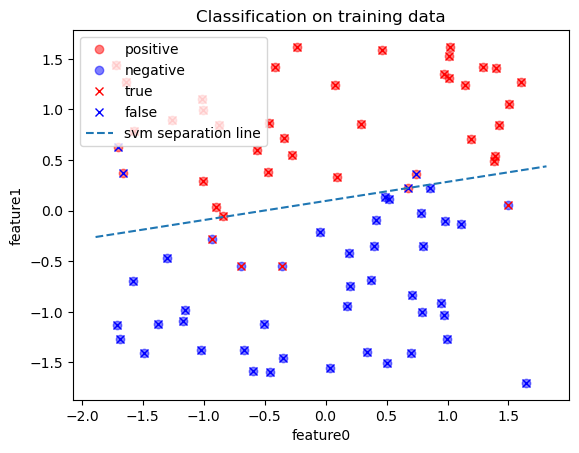

In [84]:
plt.figure()
plt.plot(X_train_norm[y_pred_train[:,0] == 1,0],X_train_norm[y_pred_train[:,0]  == 1,1], 'ro', alpha = 0.5)
plt.plot(X_train_norm[y_pred_train[:,0]  == -1,0],X_train_norm[y_pred_train[:,0]  == -1,1], 'bo', alpha = 0.5)
plt.plot(X_train_norm[label_1,0],X_train_norm[label_1,1], 'rx')
plt.plot(X_train_norm[label_minus_1,0],X_train_norm[label_minus_1,1], 'bx')
xl, xr = plt.xlim()
x_axis = np.array([xl, xr]).reshape(2,1)
y_svm = -(b + w[0] * x_axis) / w[ 1]
plt.plot(x_axis, y_svm, '--', label='SVM')

plt.legend(['positive', 'negative','true','false','svm separation line']);
plt.xlabel('feature0')
plt.ylabel('feature1');
plt.title('Classification on training data')

Na prethodnoj slici prikazane su predikcije na trenirajucem skupu a na sledecoj na testirajucem.

In [74]:
label_1_test = ((y_test == 1).T)[0]
label_minus_1_test = ((y_test == -1).T)[0]

Text(0.5, 1.0, 'Classification on test data')

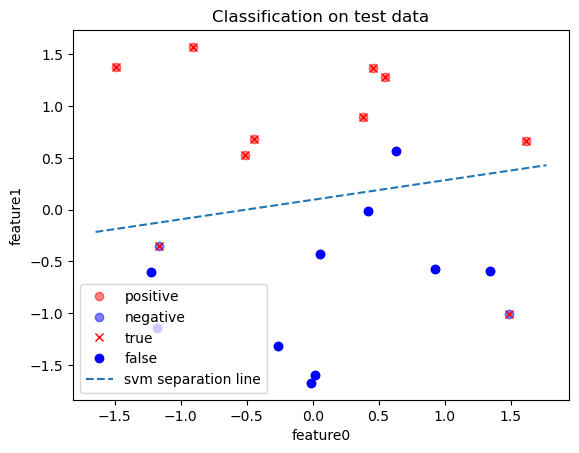

In [75]:
plt.figure()
plt.plot(X_test_norm[y_pred_test[:,0] == 1,0],X_test_norm[y_pred_test[:,0]  == 1,1], 'ro', alpha = 0.5)
plt.plot(X_test_norm[y_pred_test[:,0]  == -1,0],X_test_norm[y_pred_test[:,0]  == -1,1], 'bo', alpha = 0.5)
plt.plot(X_test_norm[label_1_test,0],X_test_norm[label_1_test,1], 'rx')
plt.plot(X_test_norm[label_minus_1_test,0],X_test_norm[label_minus_1_test,1], 'bo')
xl, xr = plt.xlim()
x_axis = np.array([xl, xr]).reshape(2,1)
y_svm = -(b + w[0] * x_axis) / w[ 1]
plt.plot(x_axis, y_svm, '--', label='SVM')

plt.legend(['positive', 'negative','true','false','svm separation line']);
plt.xlabel('feature0')
plt.ylabel('feature1');
plt.title('Classification on test data')

## Dualni problem i nelinearan kernel

Podsetimo se forme koju prima nasa funkcija: $$ min (\frac{1}{2}x^TPx+q^Tx)$$
$$ Gx \preceq h$$ $$ Ax = b\\$$ 
, ovog puta nas vektor parametara je $$ \begin{bmatrix}  \alpha_1\\ ... \\ \alpha_m\\ \end{bmatrix}$$

### 1. Racunanje matrica P i q: 

Nasa kriterijmska funkcija je $$max(-\frac{1}{2} \sum_1^m\sum_1^m \alpha_i\alpha_jy_iy_jK(x_i,x_j)+\sum_1^m \alpha_i) = min(\frac{1}{2} \sum_1^m\sum_1^m \alpha_i\alpha_jy_iy_jK(x_i,x_j)-\sum_1^m \alpha_i)$$. 

Pa je matrica P sada Y*K gde je Y = y*y.T a matrica q samo vektor -1.

### 2. Racunanje matrica G i h: 

Jedine nejednakosti koje treba da budu zadovoljene su da je $\alpha_i$ pozitivno i manje od C sto su znacajno jednostavniji uslovi nego malo pre. Iz tog razloga matrica G ce se sastojati od jedinicne i negativne jedinicne matrice dok ce h biti vektor cijih je prvih m elemenata C a poslednjih m 0.

### 3. Racunanje matrica A i b

U ovom slucaju nam jesu potrebne i matrice A i b jer imamo uslov u obliku jednakosti da je $\sum_1^m y_i \alpha_i = 0$

Iz toga mozemo zakljuciti da je A = y.T a b = 0.

S obzirom na ispunjenost KKT uslova resenje dualnog problema je ekvivalentno resenju primalnog i bice mnogo jednostavnije resiti ga zbog jednostavnijih matrica iako je njegova forma idalje kvadratna.

In [86]:
# SVM function for dual problem
def SVM_dual(X,y,C, K):
    n_samples, n_features = X.shape
   
    y = y.reshape(n_samples,1)
    Y = y*(y.T)
    
    P = K*Y
    P = cvxopt.matrix(P);

    q = -1.0*np.ones((n_samples,1))
    q = cvxopt.matrix(q);

    G = np.concatenate((np.eye(n_samples), -1.0*np.eye(n_samples)), axis = 0)
    G = cvxopt.matrix(G);

    h_high = np.ones((n_samples,1))*C
    h_low = np.zeros((n_samples,1))
    h = np.concatenate((h_high,h_low),axis = 0);
    h = cvxopt.matrix(h);
    
    A = y.T
    A = cvxopt.matrix(A);
    
    b = 0.0
    b = cvxopt.matrix(b);

    return  cvxopt.solvers.qp(P, q, G, h,A,b)['x']

### Kerneli

Dva najcesce koriscena kernela su gausov i polinomijalni kernel. Gausov kernel je slican polinomijalnom koji ima beskonacan stepen. S obzirom na izgled podataka deluje da ce polinomijalni kernel biti dovoljan ali bice isprobana oba.

In [87]:
# Kernel functions
def gaussian_kernel(X,x, sigma):
    n_samples, n_features = X.shape
    XX = X.reshape((n_samples, n_features,1));
    K = XX - x.T
    K = K*K;
    K = np.sum(K, axis = 1);
    K = np.exp(-K/2/sigma/sigma)
    return K

def polynomial_kernel(X,x,c,d):
    K = np.zeros((n_samples, n_samples))
    K = (c+np.dot(X,x.T))**d
    return K
def predict(K,alpha,y,b):
    y_pred = np.sign(((alpha*y).T)@K+b)
    return y_pred

In [88]:
def cross_validation(X,y,num_folds,fold_size,all_params, var_params, var_param_name,kernel_type):
    validation_loss_mean = []
    validation_loss_std = []
    train_loss_mean = []
    train_loss_std = []
            
    for param in var_params:
            current_train_loss = []
            current_validation_loss = []
            all_params[var_param_name] = param;
            
            for fold in range(num_folds):
                # Split data into training and validation set
                start = fold * fold_size
                end = (fold + 1) * fold_size
                
                X_validation = X[start:end]
                y_validation = y[start:end].reshape(X_validation.shape[0],1)
                
                X_train = np.concatenate((X[:start], X[end:]), axis=0)
                y_train = np.concatenate((y[:start], y[end:])).reshape(X_train.shape[0],1)
                
                # Calculate statistic of X_train
                X_mean = np.mean(X_train, axis = 0)
                X_std = np.std(X_train, axis = 0)
                
                # Standardization
                X_train = (X_train - X_mean)/X_std           
                X_validation = (X_validation - X_mean)/X_std
                
                if(kernel_type == 'P'):
                        K_train = polynomial_kernel(X_train,X_train,all_params['c'],all_params['d'])
                        K_validation = polynomial_kernel(X_train,X_validation,all_params['c'],all_params['d'])
                else:
                        K_train = gaussian_kernel(X_train,X_train,all_params['sigma'])
                        K_validation = gaussian_kernel(X_train,X_validation,all_params['sigma'])
                        
                C = all_params['C'];
                alpha = SVM_dual(X_train, y_train,C, K_train)
                alpha = np.array(alpha).reshape(X_train.shape[0],1)
             
                support_id = (np.logical_and((alpha > 1e-5), (alpha<C)).T)[0];
                support_y = y_train[support_id,:][0]
                b = (1/support_y - np.sum(alpha*y_train*((K_train[:,support_id])[:,0])))
              
                y_train_pred = predict(K_train,alpha,y_train,b ).T
                y_validation_pred = predict(K_validation,alpha,y_train,b).T
                    
                # Keep loss results 
                current_validation_loss.append(hinge_loss(y_validation_pred,y_validation))
                current_train_loss.append(hinge_loss(y_train_pred,y_train))
                
                
            # Keep statistics of loss results for this iteration
            validation_loss_mean.append(np.mean(current_validation_loss))
            validation_loss_std.append(np.std(current_validation_loss))
            train_loss_mean.append(np.mean(current_train_loss))
            train_loss_std.append(np.std(current_train_loss))
        
    # Convert lists to numpy arrays    
    validation_loss_mean = np.array(validation_loss_mean)
    validation_loss_std = np.array(validation_loss_std)
    train_loss_mean = np.array(train_loss_mean)
    train_loss_std = np.array(train_loss_std)
    
    return (validation_loss_mean,validation_loss_std,train_loss_mean,train_loss_std)

Funkcija za kros validaciju je ista kao malo pre s tim sto umesto jednog parametra sada bira recnik parametara all_params, vrednosti kroz koje treba da prodje parametar koji biramo - var_params i ime parametra koji biramo. Takodje, s obzirom da imamo dva kernela kernel_type je P za polinomijalni kernel a G za gausov.

## Biranje hiperparametara za polinomijalni kernel

In [89]:
all_params = {'C':20, 'c' : 0, 'd' : 3, 'sigma' : 1 }
var_params = [0,1,2,5,7,10, 20]
var_param_name = 'c'
kernel_type = 'P'

In [90]:
(validation_rmse_mean,validation_rmse_std,train_rmse_mean,train_rmse_std) = cross_validation(X_train,y_train,num_folds,fold_size,all_params, var_params, var_param_name,kernel_type)

     pcost       dcost       gap    pres   dres
 0: -3.2485e+02 -2.0429e+04  5e+04  7e-01  6e-14
 1: -2.2291e+02 -8.7070e+03  1e+04  1e-01  9e-14
 2: -1.6563e+02 -1.9901e+03  2e+03  2e-02  7e-14
 3: -2.2679e+02 -7.7034e+02  6e+02  6e-03  3e-14
 4: -3.2460e+02 -4.7816e+02  2e+02  7e-04  7e-14
 5: -3.6122e+02 -4.1370e+02  5e+01  1e-04  4e-14
 6: -3.7360e+02 -3.9405e+02  2e+01  4e-05  6e-14
 7: -3.7917e+02 -3.8502e+02  6e+00  7e-06  4e-14
 8: -3.8140e+02 -3.8199e+02  6e-01  5e-07  4e-14
 9: -3.8164e+02 -3.8167e+02  3e-02  1e-14  7e-14
10: -3.8166e+02 -3.8166e+02  3e-04  7e-15  6e-14
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.8901e+02 -1.5097e+04  3e+04  5e-01  7e-14
 1: -2.1895e+02 -4.8176e+03  6e+03  7e-02  6e-14
 2: -2.1069e+02 -1.0307e+03  9e+02  9e-03  5e-14
 3: -3.1954e+02 -5.5188e+02  2e+02  2e-03  4e-14
 4: -3.8562e+02 -4.6584e+02  8e+01  3e-04  4e-14
 5: -4.0056e+02 -4.3910e+02  4e+01  1e-04  5e-14
 6: -4.1508e+02 -4.1906e+02  4e+00  4e-06  5e-1

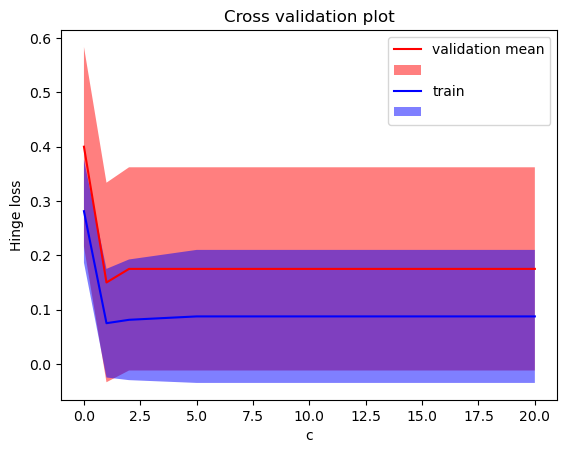

In [92]:
plt.figure()
plt.plot(var_params,validation_rmse_mean,c='r')
plt.fill_between(var_params,validation_rmse_mean-validation_rmse_std,validation_rmse_mean+validation_rmse_std, facecolor='red', alpha=0.5)
plt.plot(var_params,train_rmse_mean, c= 'b')
plt.fill_between(var_params,train_rmse_mean-train_rmse_std,train_rmse_mean+train_rmse_std, facecolor='blue', alpha=0.5)
plt.legend(['validation mean', '','train',''])
plt.title("Cross validation plot")
plt.xlabel('c')
plt.ylabel('Hinge loss')
plt.show()

In [93]:
all_params = {'C':20, 'c' : 1, 'd' : 3, 'sigma' : 1 }
var_params =  [0.001,0.002,0.005,0.008,0.01,0.02,0.05,0.08,0.1,0.2,0.5,0.8,1,2,5,8,10,20,50,80, 100,200,500,800, 1000]
var_param_name = 'C'
kernel_type = 'P'

In [94]:
(validation_rmse_mean,validation_rmse_std,train_rmse_mean,train_rmse_std) = cross_validation(X_train,y_train,num_folds,fold_size,all_params, var_params, var_param_name,kernel_type)

     pcost       dcost       gap    pres   dres
 0: -7.9132e+00 -4.2276e-01  3e+02  2e+01  7e-15
 1: -5.5916e-01 -3.4416e-01  9e+00  5e-01  8e-15
 2: -1.1427e-01 -1.4464e-01  9e-01  5e-02  1e-15
 3: -4.3362e-02 -1.1928e-01  8e-02  6e-18  1e-15
 4: -4.6804e-02 -5.7090e-02  1e-02  2e-18  6e-16
 5: -4.8680e-02 -5.2721e-02  4e-03  2e-18  4e-16
 6: -4.9657e-02 -5.0523e-02  9e-04  2e-18  4e-16
 7: -4.9966e-02 -5.0050e-02  8e-05  3e-18  5e-16
 8: -5.0001e-02 -5.0004e-02  3e-06  2e-18  5e-16
 9: -5.0002e-02 -5.0002e-02  1e-07  2e-18  5e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -7.6397e+00 -4.7445e-01  3e+02  2e+01  5e-15
 1: -6.7214e-01 -3.5278e-01  1e+01  6e-01  6e-15
 2: -1.1203e-01 -1.4654e-01  9e-01  5e-02  1e-15
 3: -4.4688e-02 -1.1904e-01  7e-02  6e-18  1e-15
 4: -4.8570e-02 -5.5321e-02  7e-03  1e-18  6e-16
 5: -4.9454e-02 -5.4366e-02  5e-03  1e-18  4e-16
 6: -5.0667e-02 -5.2025e-02  1e-03  2e-18  4e-16
 7: -5.1155e-02 -5.1373e-02  2e-04  2e-18  5e-1

 2:  2.9897e+01 -3.1266e+02  5e+02  3e-02  4e-14
 3:  1.0347e+01 -3.7497e+01  5e+01  3e-15  4e-14
 4: -1.9219e+00 -7.6022e+00  6e+00  1e-15  7e-15
 5: -4.7239e+00 -7.1495e+00  2e+00  1e-15  5e-15
 6: -5.7443e+00 -5.8731e+00  1e-01  2e-16  4e-15
 7: -5.8075e+00 -5.8097e+00  2e-03  2e-15  4e-15
 8: -5.8085e+00 -5.8085e+00  2e-05  2e-15  4e-15
 9: -5.8085e+00 -5.8085e+00  2e-07  7e-16  6e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -4.1445e+01 -3.8255e+03  1e+04  7e-01  8e-14
 1:  4.1308e+01 -1.0524e+03  2e+03  9e-02  6e-14
 2:  2.7192e+01 -2.2553e+02  3e+02  1e-02  2e-14
 3:  2.4752e+00 -5.1624e+01  6e+01  2e-03  1e-14
 4: -8.2590e+00 -2.1678e+01  1e+01  3e-04  8e-15
 5: -1.2065e+01 -1.8478e+01  7e+00  8e-05  9e-15
 6: -1.3433e+01 -1.5495e+01  2e+00  7e-06  1e-14
 7: -1.4160e+01 -1.4306e+01  1e-01  4e-07  8e-15
 8: -1.4220e+01 -1.4248e+01  3e-02  6e-09  9e-15
 9: -1.4231e+01 -1.4231e+01  4e-04  9e-11  1e-14
10: -1.4231e+01 -1.4231e+01  4e-06  9e-13  1e-

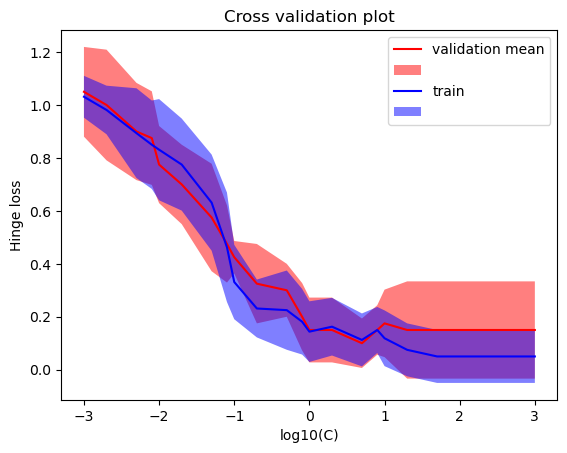

In [97]:
plt.figure()
plt.plot(np.log10(var_params),validation_rmse_mean,c='r')
plt.fill_between(np.log10(var_params),validation_rmse_mean-validation_rmse_std,validation_rmse_mean+validation_rmse_std, facecolor='red', alpha=0.5)
plt.plot(np.log10(var_params),train_rmse_mean, c= 'b')
plt.fill_between(np.log10(var_params),train_rmse_mean-train_rmse_std,train_rmse_mean+train_rmse_std, facecolor='blue', alpha=0.5)
plt.legend(['validation mean', '','train',''])
plt.title("Cross validation plot")
plt.xlabel('log10(C)')
plt.ylabel('Hinge loss')
plt.show()

In [98]:
all_params = {'C':20, 'c' : 1, 'd' : 3, 'sigma' : 1 }
var_params =  list(np.linspace(10,100,100))
var_param_name = 'C'
kernel_type = 'P'

In [99]:
(validation_rmse_mean,validation_rmse_std,train_rmse_mean,train_rmse_std) = cross_validation(X_train,y_train,num_folds,fold_size,all_params, var_params, var_param_name,kernel_type)

     pcost       dcost       gap    pres   dres
 0: -5.2775e+01 -3.7813e+03  9e+03  6e-01  9e-14
 1:  3.9208e+01 -1.1037e+03  2e+03  9e-02  9e-14
 2:  2.3736e+01 -2.2129e+02  3e+02  1e-02  4e-14
 3: -6.2432e+00 -5.5159e+01  5e+01  1e-03  2e-14
 4: -1.6515e+01 -3.0650e+01  2e+01  3e-04  1e-14
 5: -2.1269e+01 -2.3119e+01  2e+00  1e-06  1e-14
 6: -2.1947e+01 -2.2558e+01  6e-01  3e-07  9e-15
 7: -2.2222e+01 -2.2264e+01  4e-02  1e-08  1e-14
 8: -2.2241e+01 -2.2241e+01  5e-04  1e-10  9e-15
 9: -2.2241e+01 -2.2241e+01  5e-06  1e-12  1e-14
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -4.3931e+01 -4.6796e+03  1e+04  8e-01  6e-14
 1:  5.4511e+01 -1.7909e+03  3e+03  1e-01  6e-14
 2:  3.9033e+01 -2.4306e+02  4e+02  1e-02  2e-14
 3: -1.4850e+00 -6.3431e+01  7e+01  2e-03  1e-14
 4: -1.5166e+01 -3.1320e+01  2e+01  4e-04  8e-15
 5: -2.0813e+01 -2.3533e+01  3e+00  2e-06  8e-15
 6: -2.1870e+01 -2.2150e+01  3e-01  1e-07  1e-14
 7: -2.2020e+01 -2.2028e+01  9e-03  9e-10  1e-1

 7: -5.7459e+00 -5.8642e+00  1e-01  3e-15  6e-15
 8: -5.8076e+00 -5.8095e+00  2e-03  5e-16  5e-15
 9: -5.8085e+00 -5.8085e+00  2e-05  3e-15  5e-15
10: -5.8085e+00 -5.8085e+00  2e-07  3e-15  6e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  3.2642e+01 -2.2565e+04  5e+04  5e-01  2e-13
 1:  4.3861e+02 -5.6354e+03  9e+03  7e-02  1e-13
 2:  2.4290e+02 -1.1877e+03  2e+03  1e-02  5e-14
 3:  5.7555e+01 -1.4055e+02  2e+02  2e-04  5e-14
 4:  1.8850e+00 -2.9134e+01  3e+01  1e-05  1e-14
 5: -7.9805e+00 -1.9273e+01  1e+01  4e-06  1e-14
 6: -1.3749e+01 -1.7031e+01  3e+00  3e-07  1e-14
 7: -1.4889e+01 -1.5044e+01  2e-01  1e-08  1e-14
 8: -1.4963e+01 -1.4980e+01  2e-02  4e-10  1e-14
 9: -1.4970e+01 -1.4970e+01  2e-04  4e-12  9e-15
10: -1.4970e+01 -1.4970e+01  2e-06  4e-14  8e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  4.1199e+01 -1.8991e+04  4e+04  4e-01  2e-13
 1:  4.6604e+02 -4.7049e+03  8e+03  7e-02  2e-13
 2:  2.3719e+02 -1.2477

 8: -5.7994e+00 -5.8203e+00  2e-02  2e-16  7e-15
 9: -5.8084e+00 -5.8086e+00  2e-04  2e-15  5e-15
10: -5.8085e+00 -5.8085e+00  2e-06  4e-15  6e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.3479e+02 -5.2228e+04  1e+05  5e-01  3e-13
 1:  1.1174e+03 -1.2832e+04  2e+04  7e-02  2e-13
 2:  6.0442e+02 -2.6799e+03  4e+03  1e-02  9e-14
 3:  1.5177e+02 -3.2884e+02  5e+02  1e-04  9e-14
 4:  1.3303e+01 -4.1750e+01  6e+01  5e-08  2e-14
 5: -4.6821e+00 -1.9826e+01  2e+01  1e-08  1e-14
 6: -1.3116e+01 -1.7674e+01  5e+00  2e-09  1e-14
 7: -1.4841e+01 -1.5050e+01  2e-01  4e-11  1e-14
 8: -1.4938e+01 -1.4989e+01  5e-02  8e-12  1e-14
 9: -1.4969e+01 -1.4971e+01  2e-03  5e-14  8e-15
10: -1.4970e+01 -1.4970e+01  2e-05  1e-15  1e-14
11: -1.4970e+01 -1.4970e+01  2e-07  5e-15  1e-14
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.6946e+02 -4.3733e+04  9e+04  4e-01  2e-13
 1:  1.2143e+03 -1.0132e+04  2e+04  6e-02  2e-13
 2:  5.8499e+02 -2.7118

 8: -5.7656e+00 -5.8495e+00  8e-02  3e-16  6e-15
 9: -5.8080e+00 -5.8090e+00  9e-04  2e-16  6e-15
10: -5.8085e+00 -5.8085e+00  9e-06  9e-16  6e-15
11: -5.8085e+00 -5.8085e+00  9e-08  2e-15  5e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  5.6522e+02 -9.4132e+04  2e+05  5e-01  4e-13
 1:  2.1032e+03 -2.2946e+04  4e+04  7e-02  3e-13
 2:  1.1246e+03 -4.7616e+03  7e+03  1e-02  1e-13
 3:  2.8441e+02 -5.7584e+02  9e+02  1e-04  3e-13
 4:  3.2710e+01 -7.0423e+01  1e+02  7e-07  3e-14
 5: -1.6197e+00 -2.1795e+01  2e+01  9e-08  1e-14
 6: -9.9803e+00 -1.7761e+01  8e+00  3e-08  7e-15
 7: -1.4524e+01 -1.5616e+01  1e+00  1e-10  1e-14
 8: -1.4908e+01 -1.5047e+01  1e-01  2e-11  2e-14
 9: -1.4964e+01 -1.4979e+01  1e-02  4e-15  1e-14
10: -1.4970e+01 -1.4970e+01  1e-04  4e-15  1e-14
11: -1.4970e+01 -1.4970e+01  1e-06  3e-15  8e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  6.4096e+02 -7.8619e+04  2e+05  4e-01  4e-13
 1:  2.3091e+03 -1.7504

 5: -5.3636e+00 -4.5269e+01  4e+01  6e-15  2e-14
 6: -2.2554e+01 -4.8092e+01  3e+01  5e-15  3e-14
 7: -3.4082e+01 -3.8378e+01  4e+00  2e-16  2e-14
 8: -3.6195e+01 -3.6467e+01  3e-01  8e-15  2e-14
 9: -3.6335e+01 -3.6338e+01  3e-03  8e-15  2e-14
10: -3.6336e+01 -3.6336e+01  3e-05  1e-15  2e-14
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  9.3834e+02 -1.2797e+05  3e+05  4e-01  5e-13
 1:  3.2615e+03 -3.9642e+04  7e+04  9e-02  4e-13
 2:  1.9786e+03 -1.0304e+04  2e+04  2e-02  1e-13
 3:  5.5046e+02 -8.1393e+02  1e+03  2e-04  3e-13
 4:  7.3528e+01 -1.0951e+02  2e+02  1e-15  3e-14
 5:  6.0836e+00 -1.9468e+01  3e+01  6e-16  2e-14
 6: -1.9726e+00 -7.1157e+00  5e+00  3e-16  5e-15
 7: -4.7162e+00 -6.9687e+00  2e+00  2e-16  4e-15
 8: -5.7468e+00 -5.8634e+00  1e-01  1e-15  5e-15
 9: -5.8076e+00 -5.8095e+00  2e-03  3e-16  5e-15
10: -5.8085e+00 -5.8085e+00  2e-05  2e-15  5e-15
11: -5.8085e+00 -5.8085e+00  2e-07  3e-15  5e-15
Optimal solution found.
     pcost       dcost

 1:  5.4169e+03 -3.7301e+04  6e+04  5e-02  5e-13
 2:  2.3137e+03 -8.2547e+03  1e+04  5e-03  2e-13
 3:  4.6461e+02 -7.6363e+02  1e+03  7e-05  9e-14
 4:  5.4091e+01 -1.0262e+02  2e+02  5e-15  3e-14
 5: -1.5864e-02 -2.8302e+01  3e+01  5e-15  1e-14
 6: -1.2062e+01 -2.0618e+01  9e+00  4e-15  8e-15
 7: -1.6464e+01 -1.9884e+01  3e+00  1e-15  1e-14
 8: -1.7891e+01 -1.8370e+01  5e-01  3e-16  1e-14
 9: -1.8111e+01 -1.8123e+01  1e-02  2e-16  1e-14
10: -1.8117e+01 -1.8118e+01  3e-04  1e-15  1e-14
11: -1.8117e+01 -1.8117e+01  3e-06  2e-15  1e-14
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.5715e+03 -2.1175e+05  5e+05  5e-01  6e-13
 1:  5.6093e+03 -5.1959e+04  8e+04  6e-02  4e-13
 2:  2.5855e+03 -9.4029e+03  1e+04  7e-03  2e-13
 3:  6.1848e+02 -1.3101e+03  2e+03  5e-04  1e-13
 4:  7.5059e+01 -1.4695e+02  2e+02  5e-15  3e-14
 5: -4.4351e+00 -4.5639e+01  4e+01  2e-15  2e-14
 6: -2.3495e+01 -4.8518e+01  3e+01  2e-15  2e-14
 7: -3.4175e+01 -3.8498e+01  4e+00  6e-15  3e-

11: -1.4970e+01 -1.4970e+01  7e-06  2e-15  1e-14
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.5069e+03 -2.3542e+05  5e+05  4e-01  5e-13
 1:  7.3879e+03 -4.9485e+04  8e+04  4e-02  6e-13
 2:  3.1417e+03 -1.1182e+04  2e+04  5e-03  2e-13
 3:  6.2802e+02 -1.0082e+03  2e+03  6e-05  7e-14
 4:  7.6760e+01 -1.3293e+02  2e+02  1e-14  5e-14
 5:  2.1167e+00 -3.0488e+01  3e+01  1e-15  1e-14
 6: -1.1271e+01 -2.0655e+01  9e+00  1e-16  9e-15
 7: -1.5916e+01 -2.0265e+01  4e+00  2e-15  1e-14
 8: -1.7837e+01 -1.8406e+01  6e-01  1e-15  1e-14
 9: -1.8108e+01 -1.8126e+01  2e-02  2e-15  1e-14
10: -1.8117e+01 -1.8118e+01  4e-04  2e-16  1e-14
11: -1.8117e+01 -1.8117e+01  5e-06  3e-16  1e-14
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.2423e+03 -2.8410e+05  6e+05  5e-01  6e-13
 1:  7.6140e+03 -6.9591e+04  1e+05  6e-02  7e-13
 2:  3.4965e+03 -1.2503e+04  2e+04  7e-03  3e-13
 3:  8.3837e+02 -1.7334e+03  3e+03  4e-04  9e-14
 4:  1.0773e+02 -1.9013

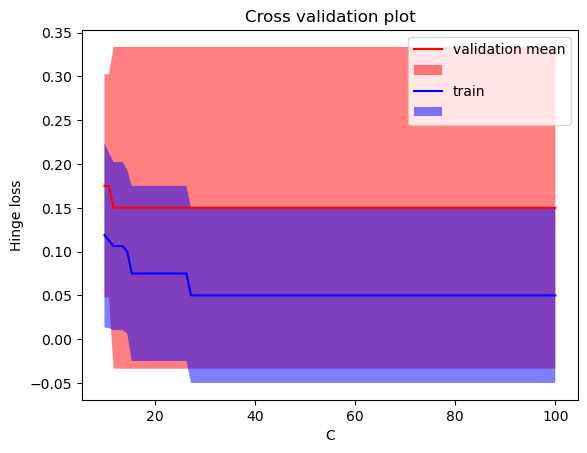

In [101]:
plt.figure()
plt.plot(var_params,validation_rmse_mean,c='r')
plt.fill_between(var_params,validation_rmse_mean-validation_rmse_std,validation_rmse_mean+validation_rmse_std, facecolor='red', alpha=0.5)
plt.plot(var_params,train_rmse_mean, c= 'b')
plt.fill_between(var_params,train_rmse_mean-train_rmse_std,train_rmse_mean+train_rmse_std, facecolor='blue', alpha=0.5)
plt.legend(['validation mean', '','train',''])
plt.title("Cross validation plot")
plt.xlabel('C')
plt.ylabel('Hinge loss')
plt.show()

Da ne bi doslo do preobucavanja uzeto je C = 10

In [102]:
all_params = {'C':10, 'c' : 1, 'd' : 3, 'sigma' : 1 }
var_params =  [1,2,3,4,5,6,7,8,9,10,11,12]
var_param_name = 'd'
kernel_type = 'P'

In [103]:
(validation_rmse_mean,validation_rmse_std,train_rmse_mean,train_rmse_std) = cross_validation(X_train,y_train,num_folds,fold_size,all_params, var_params, var_param_name,kernel_type)

     pcost       dcost       gap    pres   dres
 0: -1.0415e+02 -3.9987e+03  8e+03  6e-01  8e-15
 1: -6.6899e+01 -8.5923e+02  8e+02  4e-16  1e-14
 2: -1.2402e+02 -2.7455e+02  2e+02  2e-14  1e-14
 3: -1.5268e+02 -2.1904e+02  7e+01  3e-14  1e-14
 4: -1.6360e+02 -1.9322e+02  3e+01  8e-15  1e-14
 5: -1.7035e+02 -1.8280e+02  1e+01  3e-15  1e-14
 6: -1.7455e+02 -1.7775e+02  3e+00  1e-14  1e-14
 7: -1.7584e+02 -1.7613e+02  3e-01  6e-15  1e-14
 8: -1.7596e+02 -1.7597e+02  9e-03  6e-15  1e-14
 9: -1.7596e+02 -1.7596e+02  9e-05  5e-15  1e-14
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.1588e+02 -2.9087e+03  5e+03  3e-01  1e-14
 1: -1.1561e+02 -5.3577e+02  5e+02  1e-02  9e-15
 2: -1.5751e+02 -2.8432e+02  1e+02  3e-03  1e-14
 3: -1.8137e+02 -2.5715e+02  8e+01  2e-03  1e-14
 4: -1.9077e+02 -2.4353e+02  5e+01  1e-03  1e-14
 5: -1.9957e+02 -2.2648e+02  3e+01  3e-04  1e-14
 6: -2.0587e+02 -2.1921e+02  1e+01  1e-04  1e-14
 7: -2.0975e+02 -2.1436e+02  5e+00  3e-05  9e-1

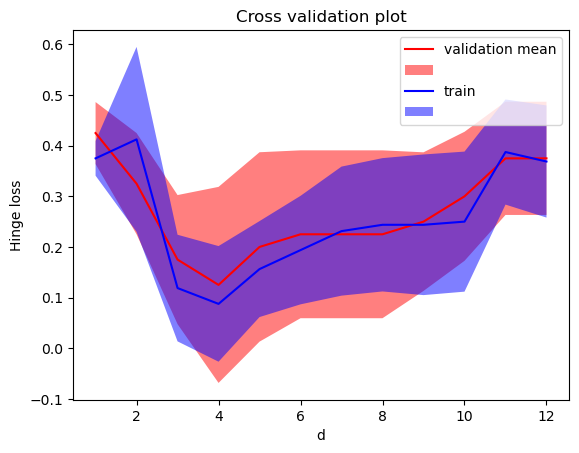

In [110]:
plt.figure()
plt.plot(var_params,validation_rmse_mean,c='r')
plt.fill_between(var_params,validation_rmse_mean-validation_rmse_std,validation_rmse_mean+validation_rmse_std, facecolor='red', alpha=0.5)
plt.plot(var_params,train_rmse_mean, c= 'b')
plt.fill_between(var_params,train_rmse_mean-train_rmse_std,train_rmse_mean+train_rmse_std, facecolor='blue', alpha=0.5)
plt.legend(['validation mean', '','train',''])
plt.title("Cross validation plot")
plt.xlabel('d')
plt.ylabel('Hinge loss')
plt.show()

In [105]:
C_opt = 10
c_opt = 1
d_opt = 4

In [106]:
K_train =  polynomial_kernel(X_train_norm,X_train_norm,c_opt, d_opt)
alpha = SVM_dual(X_train_norm, y_train, C_opt, K_train)
alpha = np.array(alpha).reshape(X_train.shape[0],1)

     pcost       dcost       gap    pres   dres
 0: -7.7833e+01 -5.2860e+03  1e+04  7e-01  4e-13
 1:  9.5174e+00 -1.7254e+03  3e+03  1e-01  4e-13
 2:  2.9745e+01 -3.6486e+02  6e+02  2e-02  8e-14
 3:  5.1854e+00 -8.1707e+01  1e+02  3e-03  3e-14
 4: -7.6442e+00 -2.6008e+01  2e+01  5e-04  2e-14
 5: -1.2769e+01 -1.8905e+01  6e+00  7e-05  1e-14
 6: -1.4636e+01 -1.5472e+01  8e-01  1e-06  2e-14
 7: -1.4906e+01 -1.5102e+01  2e-01  2e-07  2e-14
 8: -1.4990e+01 -1.5006e+01  2e-02  3e-15  2e-14
 9: -1.4997e+01 -1.4997e+01  3e-04  3e-15  1e-14
10: -1.4997e+01 -1.4997e+01  3e-06  3e-15  2e-14
Optimal solution found.


In [107]:
support_id = (np.logical_and((alpha > 1e-5), (alpha<C_opt)).T)[0];
support_y = y_train[support_id][0]
b = (1/support_y - np.sum(alpha*y_train*((K_train[:,support_id])[:,0])))

Text(0.5, 1.0, 'Classification')

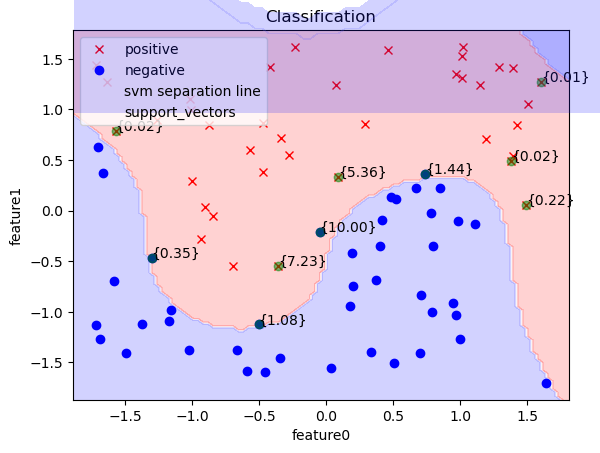

In [121]:
plt.figure()
label_1 = ((y_train == 1).T)[0]
label_minus_1 = ((y_train == -1).T)[0]
plt.plot(X_train_norm[label_1,0],X_train_norm[label_1,1], 'rx')
plt.plot(X_train_norm[label_minus_1,0],X_train_norm[label_minus_1,1], 'bo')
def plot_decision_boundary( xmin, xmax, ymin, ymax):
  xx, yy = np.meshgrid(
      np.linspace(xmin, xmax, num=100, endpoint=True), 
      np.linspace(ymin, ymax, num=100, endpoint=True))
  K = polynomial_kernel(X_train_norm, np.c_[xx.ravel(), yy.ravel()],c_opt,d_opt)
  Z = predict(K,alpha,y_train,b)
  Z = Z.reshape(xx.shape)
  cs = plt.contourf(xx, yy, Z, alpha=0.2, cmap='bwr')
xmin, xmax, ymin, ymax = plt.axis()
plot_decision_boundary( xmin, xmax, ymin, ymax) 

for i, txt in enumerate(alpha):
    if(txt > 1e-5):
       plt.annotate('{%.2f}'%(txt), (X_train_norm[i,0], X_train_norm[i,1]))
       plt.plot(X_train_norm[i,0], X_train_norm[i,1],'go', alpha = 0.5)
       
plt.legend(['positive', 'negative','svm separation line','support_vectors']);
plt.xlabel('feature0')
plt.ylabel('feature1');
plt.title('Classification')

Vidimo da je granica malo pomerena na ustrb plavih primera iako je mogla 100% da klasifikuje sve primere da ne bi doslo do preobucavanja uslad loseg klasifikovanja crvenih primera na test skupu.

In [111]:
K_test = polynomial_kernel(X_train_norm,X_test_norm,c_opt,d_opt)
y_pred_train = predict(K_train, alpha, y_train,b).T
acc_train = np.sum(y_pred_train == y_train)/len(y_train)
y_test = y_test.reshape(X_test.shape[0],1)
y_pred_test = predict(K_test, alpha, y_train,b).T
acc_test = np.sum(y_pred_test == y_test)/len(y_test)
train_loss = hinge_loss(y_pred_train, y_train)
test_loss = hinge_loss(y_pred_test, y_test)
print(acc_train)
print(acc_test)
print(train_loss)
print(test_loss)

0.95
0.9


#### Krajnja tacnost polinomijalnog modela je 95% na obucavajucem skupu i 90% na test skupu.

Mozemo videti da je i gubitak manji nego kod linearnog kernela i da je malo veci na testirajucem skupu.

## Odredjivanje hiperparametara gausovog kernela

In [115]:
all_params = {'C':10, 'c' : 1, 'd' : 4, 'sigma' : 1 }
var_params = [0.1,0.5,1,2,5,7,10, 20,30]
var_param_name = 'sigma'
kernel_type = 'G'

In [116]:
(validation_rmse_mean,validation_rmse_std,train_rmse_mean,train_rmse_std) = cross_validation(X_train,y_train,num_folds,fold_size,all_params, var_params, var_param_name,kernel_type)

     pcost       dcost       gap    pres   dres
 0:  2.1940e+02 -1.5652e+03  2e+03  2e-15  2e-15
 1:  2.0366e+01 -1.7714e+02  2e+02  2e-15  1e-15
 2: -2.5680e+01 -4.9069e+01  2e+01  8e-15  5e-16
 3: -2.8161e+01 -2.9322e+01  1e+00  3e-15  2e-16
 4: -2.8178e+01 -2.8241e+01  6e-02  1e-15  1e-16
 5: -2.8178e+01 -2.8179e+01  1e-03  4e-15  1e-16
 6: -2.8178e+01 -2.8178e+01  1e-05  3e-15  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.2743e+02 -1.6854e+03  2e+03  1e-15  2e-15
 1:  2.4535e+01 -1.8309e+02  2e+02  7e-15  1e-15
 2: -2.4511e+01 -4.9219e+01  2e+01  4e-15  4e-16
 3: -2.7304e+01 -2.8628e+01  1e+00  3e-16  2e-16
 4: -2.7339e+01 -2.7446e+01  1e-01  2e-16  1e-16
 5: -2.7344e+01 -2.7348e+01  3e-03  7e-16  1e-16
 6: -2.7345e+01 -2.7345e+01  1e-04  4e-16  1e-16
 7: -2.7345e+01 -2.7345e+01  2e-06  1e-15  9e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.3598e+02 -1.6987e+03  2e+03  3e-15  2e-15
 1:  2.6368e+01 -1.8011e

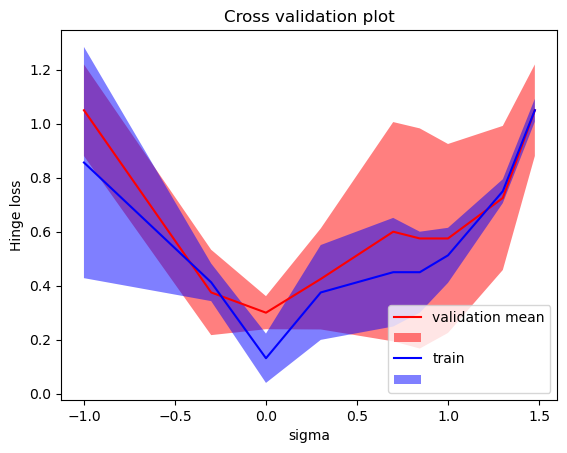

In [118]:
plt.figure()
plt.plot(np.log10(var_params),validation_rmse_mean,c='r')
plt.fill_between(np.log10(var_params),validation_rmse_mean-validation_rmse_std,validation_rmse_mean+validation_rmse_std, facecolor='red', alpha=0.5)
plt.plot(np.log10(var_params),train_rmse_mean, c= 'b')
plt.fill_between(np.log10(var_params),train_rmse_mean-train_rmse_std,train_rmse_mean+train_rmse_std, facecolor='blue', alpha=0.5)
plt.legend(['validation mean', '','train',''])
plt.title("Cross validation plot")
plt.xlabel('sigma')
plt.ylabel('Hinge loss')
plt.show()

In [143]:
all_params = {'C':20, 'c' : 2, 'd' : 3, 'sigma' : 1 }
var_params =  [0.001,0.002,0.005,0.008,0.01,0.02,0.05,0.08,0.1,0.2,0.5,0.8,1,2,5,8,10,20,50,80, 100,200,500,800, 1000]
var_param_name = 'C'
kernel_type = 'G'

In [144]:
(validation_rmse_mean,validation_rmse_std,train_rmse_mean,train_rmse_std) = cross_validation(X_train,y_train,num_folds,fold_size,all_params, var_params, var_param_name,kernel_type)

     pcost       dcost       gap    pres   dres
 0: -9.7652e+00 -2.2225e+00  4e+02  2e+01  4e-16
 1: -2.5725e+00 -8.9610e-01  2e+01  1e+00  7e-16
 2: -1.1729e-01 -1.5026e-01  7e-01  3e-02  1e-15
 3: -5.0760e-02 -1.2272e-01  7e-02  4e-18  7e-16
 4: -5.6253e-02 -6.8871e-02  1e-02  1e-18  7e-16
 5: -5.7777e-02 -5.8162e-02  4e-04  2e-18  6e-16
 6: -5.7808e-02 -5.7890e-02  8e-05  2e-18  5e-16
 7: -5.7826e-02 -5.7849e-02  2e-05  2e-18  5e-16
 8: -5.7832e-02 -5.7835e-02  3e-06  2e-18  5e-16
 9: -5.7833e-02 -5.7834e-02  8e-07  1e-18  5e-16
10: -5.7833e-02 -5.7833e-02  6e-08  2e-18  6e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0126e+01 -2.3395e+00  3e+02  2e+01  5e-16
 1: -2.5895e+00 -8.4808e-01  2e+01  1e+00  5e-16
 2: -1.0109e-01 -1.4627e-01  6e-01  3e-02  2e-15
 3: -5.1301e-02 -1.1529e-01  6e-02  4e-18  8e-16
 4: -5.8164e-02 -6.7831e-02  1e-02  1e-18  6e-16
 5: -5.9778e-02 -6.0217e-02  4e-04  3e-18  5e-16
 6: -5.9801e-02 -5.9871e-02  7e-05  2e-18  5e-1

 2: -3.1892e+01 -7.1365e+01  4e+01  1e-03  1e-15
 3: -4.0761e+01 -5.9223e+01  2e+01  5e-04  1e-15
 4: -4.4607e+01 -5.1853e+01  7e+00  6e-05  1e-15
 5: -4.7165e+01 -4.9209e+01  2e+00  1e-06  1e-15
 6: -4.7737e+01 -4.8071e+01  3e-01  2e-07  1e-15
 7: -4.7843e+01 -4.7861e+01  2e-02  8e-10  1e-15
 8: -4.7851e+01 -4.7851e+01  3e-04  1e-11  2e-15
 9: -4.7851e+01 -4.7851e+01  3e-06  1e-13  2e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  6.3325e+01 -1.6136e+03  2e+03  2e-01  3e-15
 1:  4.9888e+00 -2.2121e+02  2e+02  1e-02  2e-15
 2: -3.6779e+01 -1.1754e+02  8e+01  3e-03  2e-15
 3: -5.2943e+01 -8.3895e+01  3e+01  7e-04  2e-15
 4: -6.1171e+01 -7.4214e+01  1e+01  1e-04  2e-15
 5: -6.5210e+01 -6.7694e+01  2e+00  1e-05  2e-15
 6: -6.6076e+01 -6.6344e+01  3e-01  1e-06  3e-15
 7: -6.6182e+01 -6.6186e+01  4e-03  9e-09  3e-15
 8: -6.6184e+01 -6.6184e+01  1e-04  1e-10  3e-15
 9: -6.6184e+01 -6.6184e+01  2e-06  1e-12  3e-15
Optimal solution found.
     pcost       dcost

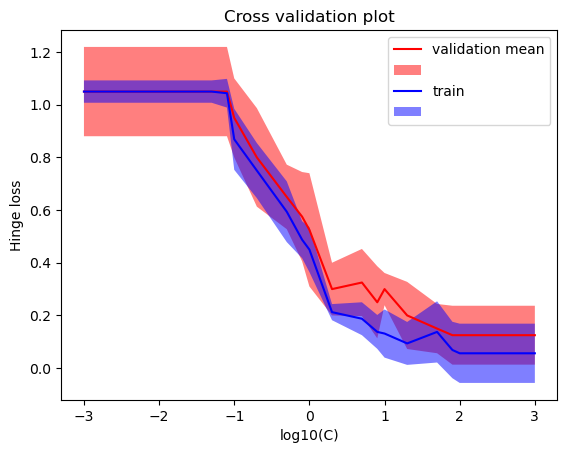

In [145]:
plt.figure()
plt.plot(np.log10(var_params),validation_rmse_mean,c='r')
plt.fill_between(np.log10(var_params),validation_rmse_mean-validation_rmse_std,validation_rmse_mean+validation_rmse_std, facecolor='red', alpha=0.5)
plt.plot(np.log10(var_params),train_rmse_mean, c= 'b')
plt.fill_between(np.log10(var_params),train_rmse_mean-train_rmse_std,train_rmse_mean+train_rmse_std, facecolor='blue', alpha=0.5)
plt.legend(['validation mean', '','train',''])
plt.title("Cross validation plot")
plt.xlabel('log10(C)')
plt.ylabel('Hinge loss')
plt.show()

In [146]:
all_params = {'C':20, 'c' : 1, 'd' : 3, 'sigma' : 1 }
var_params =  list(np.linspace(10,100,100))
var_param_name = 'C'
kernel_type = 'P'

In [147]:
(validation_rmse_mean,validation_rmse_std,train_rmse_mean,train_rmse_std) = cross_validation(X_train,y_train,num_folds,fold_size,all_params, var_params, var_param_name,kernel_type)

     pcost       dcost       gap    pres   dres
 0: -5.2775e+01 -3.7813e+03  9e+03  6e-01  9e-14
 1:  3.9208e+01 -1.1037e+03  2e+03  9e-02  9e-14
 2:  2.3736e+01 -2.2129e+02  3e+02  1e-02  4e-14
 3: -6.2432e+00 -5.5159e+01  5e+01  1e-03  2e-14
 4: -1.6515e+01 -3.0650e+01  2e+01  3e-04  1e-14
 5: -2.1269e+01 -2.3119e+01  2e+00  1e-06  1e-14
 6: -2.1947e+01 -2.2558e+01  6e-01  3e-07  9e-15
 7: -2.2222e+01 -2.2264e+01  4e-02  1e-08  1e-14
 8: -2.2241e+01 -2.2241e+01  5e-04  1e-10  9e-15
 9: -2.2241e+01 -2.2241e+01  5e-06  1e-12  1e-14
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -4.3931e+01 -4.6796e+03  1e+04  8e-01  6e-14
 1:  5.4511e+01 -1.7909e+03  3e+03  1e-01  6e-14
 2:  3.9033e+01 -2.4306e+02  4e+02  1e-02  2e-14
 3: -1.4850e+00 -6.3431e+01  7e+01  2e-03  1e-14
 4: -1.5166e+01 -3.1320e+01  2e+01  4e-04  8e-15
 5: -2.0813e+01 -2.3533e+01  3e+00  2e-06  8e-15
 6: -2.1870e+01 -2.2150e+01  3e-01  1e-07  1e-14
 7: -2.2020e+01 -2.2028e+01  9e-03  9e-10  1e-1

 9: -1.8117e+01 -1.8117e+01  2e-04  3e-11  1e-14
10: -1.8117e+01 -1.8117e+01  2e-06  3e-13  1e-14
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.4201e-01 -2.0846e+04  5e+04  5e-01  2e-13
 1:  4.4212e+02 -5.4140e+03  9e+03  7e-02  2e-13
 2:  2.2057e+02 -1.0724e+03  2e+03  1e-02  7e-14
 3:  3.4739e+01 -1.0256e+02  1e+02  2e-04  4e-14
 4: -9.1927e+00 -4.8781e+01  4e+01  5e-05  2e-14
 5: -2.9105e+01 -4.6215e+01  2e+01  6e-06  2e-14
 6: -3.2137e+01 -4.0699e+01  9e+00  8e-15  2e-14
 7: -3.5576e+01 -3.6527e+01  1e+00  8e-15  2e-14
 8: -3.6006e+01 -3.6016e+01  1e-02  9e-15  2e-14
 9: -3.6011e+01 -3.6011e+01  1e-04  9e-15  2e-14
10: -3.6011e+01 -3.6011e+01  1e-06  6e-16  2e-14
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  4.3116e+01 -2.6343e+04  7e+04  7e-01  2e-13
 1:  5.2962e+02 -9.1599e+03  2e+04  1e-01  2e-13
 2:  2.9477e+02 -1.1622e+03  2e+03  1e-02  8e-14
 3:  4.7840e+01 -1.1629e+02  2e+02  1e-04  4e-14
 4: -7.8981e+00 -4.7817

     pcost       dcost       gap    pres   dres
 0:  2.6427e+02 -6.0012e+04  2e+05  7e-01  3e-13
 1:  1.3306e+03 -2.0251e+04  3e+04  1e-01  2e-13
 2:  7.0562e+02 -2.6296e+03  4e+03  1e-02  1e-13
 3:  1.6250e+02 -3.8542e+02  6e+02  7e-04  3e-14
 4:  6.6494e+00 -5.7914e+01  6e+01  1e-05  2e-14
 5: -1.8269e+01 -4.4081e+01  3e+01  3e-06  2e-14
 6: -3.2889e+01 -3.9601e+01  7e+00  5e-07  2e-14
 7: -3.6015e+01 -3.6658e+01  6e-01  3e-08  2e-14
 8: -3.6333e+01 -3.6339e+01  6e-03  3e-10  2e-14
 9: -3.6336e+01 -3.6336e+01  6e-05  3e-12  2e-14
10: -3.6336e+01 -3.6336e+01  6e-07  3e-14  2e-14
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.5468e+02 -4.1447e+04  9e+04  4e-01  4e-13
 1:  9.5839e+02 -1.2665e+04  2e+04  9e-02  3e-13
 2:  6.0459e+02 -3.3515e+03  5e+03  2e-02  8e-14
 3:  1.6940e+02 -2.7364e+02  5e+02  2e-04  1e-13
 4:  1.9564e+01 -3.9086e+01  6e+01  9e-16  2e-14
 5: -8.7112e-01 -8.4362e+00  8e+00  5e-16  7e-15
 6: -3.6862e+00 -6.8201e+00  3e+00  7e-16  4e-1

 9: -5.8081e+00 -5.8089e+00  8e-04  3e-16  4e-15
10: -5.8085e+00 -5.8085e+00  8e-06  1e-15  5e-15
11: -5.8085e+00 -5.8085e+00  8e-08  2e-16  6e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  5.4081e+02 -9.1155e+04  2e+05  5e-01  3e-13
 1:  2.0326e+03 -2.2228e+04  4e+04  7e-02  3e-13
 2:  1.0874e+03 -4.6142e+03  7e+03  1e-02  1e-13
 3:  2.7498e+02 -5.5863e+02  8e+02  1e-04  6e-14
 4:  3.1341e+01 -6.8435e+01  1e+02  7e-07  3e-14
 5: -1.7380e+00 -2.1774e+01  2e+01  9e-08  1e-14
 6: -1.0088e+01 -1.7709e+01  8e+00  3e-08  1e-14
 7: -1.4545e+01 -1.5578e+01  1e+00  8e-11  1e-14
 8: -1.4908e+01 -1.5046e+01  1e-01  1e-11  1e-14
 9: -1.4964e+01 -1.4979e+01  1e-02  1e-15  1e-14
10: -1.4970e+01 -1.4970e+01  1e-04  2e-15  1e-14
11: -1.4970e+01 -1.4970e+01  1e-06  7e-15  1e-14
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  6.1354e+02 -7.6141e+04  2e+05  4e-01  4e-13
 1:  2.2306e+03 -1.6987e+04  3e+04  5e-02  4e-13
 2:  1.0302e+03 -4.3635

 2:  1.9270e+03 -1.0046e+04  2e+04  2e-02  1e-13
 3:  5.3618e+02 -7.9397e+02  1e+03  2e-04  8e-14
 4:  7.1487e+01 -1.0694e+02  2e+02  3e-15  4e-14
 5:  5.8193e+00 -1.9068e+01  2e+01  1e-15  1e-14
 6: -2.0015e+00 -7.1013e+00  5e+00  1e-15  7e-15
 7: -4.7095e+00 -6.9730e+00  2e+00  3e-16  4e-15
 8: -5.7474e+00 -5.8625e+00  1e-01  3e-15  6e-15
 9: -5.8076e+00 -5.8094e+00  2e-03  2e-16  5e-15
10: -5.8085e+00 -5.8085e+00  2e-05  3e-15  6e-15
11: -5.8085e+00 -5.8085e+00  2e-07  3e-16  6e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  9.9149e+02 -1.4453e+05  3e+05  5e-01  4e-13
 1:  3.3062e+03 -3.5078e+04  6e+04  7e-02  4e-13
 2:  1.7563e+03 -7.2484e+03  1e+04  1e-02  2e-13
 3:  4.4395e+02 -8.6276e+02  1e+03  7e-05  7e-14
 4:  5.5829e+01 -1.0344e+02  2e+02  6e-07  3e-14
 5:  1.7604e+00 -2.5360e+01  3e+01  5e-08  1e-14
 6: -8.0045e+00 -1.8727e+01  1e+01  2e-08  1e-14
 7: -1.3816e+01 -1.6760e+01  3e+00  1e-09  1e-14
 8: -1.4896e+01 -1.5031e+01  1e-01  5e-11  1e-

     pcost       dcost       gap    pres   dres
 0:  1.4908e+03 -2.0291e+05  4e+05  5e-01  6e-13
 1:  5.3651e+03 -4.9802e+04  8e+04  6e-02  5e-13
 2:  2.4743e+03 -9.0225e+03  1e+04  7e-03  2e-13
 3:  5.9153e+02 -1.2577e+03  2e+03  5e-04  1e-13
 4:  7.1046e+01 -1.4160e+02  2e+02  4e-15  5e-14
 5: -4.8252e+00 -4.5610e+01  4e+01  4e-16  2e-14
 6: -2.5348e+01 -4.8480e+01  2e+01  8e-16  3e-14
 7: -3.4287e+01 -3.8726e+01  4e+00  5e-15  2e-14
 8: -3.6171e+01 -3.6585e+01  4e-01  8e-16  3e-14
 9: -3.6360e+01 -3.6365e+01  4e-03  3e-15  3e-14
10: -3.6362e+01 -3.6362e+01  4e-05  4e-16  2e-14
11: -3.6362e+01 -3.6362e+01  4e-07  2e-15  2e-14
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.8813e+03 -2.5944e+05  6e+05  7e-01  6e-13
 1:  6.2978e+03 -8.4592e+04  1e+05  9e-02  6e-13
 2:  3.1774e+03 -1.1129e+04  2e+04  9e-03  2e-13
 3:  8.3258e+02 -1.8079e+03  3e+03  9e-04  7e-14
 4:  1.1392e+02 -2.0148e+02  3e+02  3e-15  4e-14
 5:  1.9548e-01 -4.9587e+01  5e+01  2e-15  2e-1

 6: -2.2227e+01 -4.3380e+01  2e+01  7e-15  2e-14
 7: -3.3698e+01 -3.8493e+01  5e+00  6e-15  2e-14
 8: -3.6151e+01 -3.6498e+01  3e-01  7e-15  2e-14
 9: -3.6334e+01 -3.6338e+01  3e-03  6e-15  2e-14
10: -3.6336e+01 -3.6336e+01  3e-05  4e-15  2e-14
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.0639e+03 -2.3928e+05  5e+05  4e-01  5e-13
 1:  6.3007e+03 -7.4469e+04  1e+05  9e-02  7e-13
 2:  3.7710e+03 -1.9213e+04  3e+04  2e-02  3e-13
 3:  1.0450e+03 -1.5001e+03  3e+03  2e-04  4e-13
 4:  1.4471e+02 -1.9762e+02  3e+02  1e-14  5e-14
 5:  1.5421e+01 -3.3020e+01  5e+01  5e-15  2e-14
 6: -1.3984e+00 -7.4513e+00  6e+00  7e-16  7e-15
 7: -4.7206e+00 -6.8378e+00  2e+00  2e-16  7e-15
 8: -5.7617e+00 -5.8621e+00  1e-01  2e-15  6e-15
 9: -5.8078e+00 -5.8095e+00  2e-03  1e-15  8e-15
10: -5.8085e+00 -5.8085e+00  2e-05  4e-15  6e-15
11: -5.8085e+00 -5.8085e+00  2e-07  8e-16  4e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.1823e+03 -2.7762

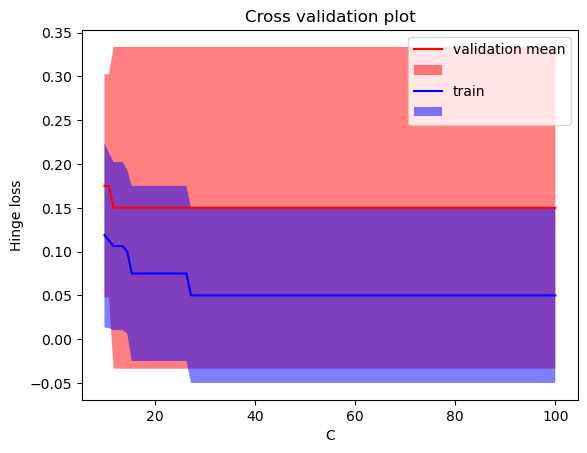

In [148]:
plt.figure()
plt.plot(var_params,validation_rmse_mean,c='r')
plt.fill_between(var_params,validation_rmse_mean-validation_rmse_std,validation_rmse_mean+validation_rmse_std, facecolor='red', alpha=0.5)
plt.plot(var_params,train_rmse_mean, c= 'b')
plt.fill_between(var_params,train_rmse_mean-train_rmse_std,train_rmse_mean+train_rmse_std, facecolor='blue', alpha=0.5)
plt.legend(['validation mean', '','train',''])
plt.title("Cross validation plot")
plt.xlabel('C')
plt.ylabel('Hinge loss')
plt.show()

In [149]:
C_opt = 10

In [150]:
sigma_opt = 1;

In [151]:
K_train =  gaussian_kernel(X_train_norm,X_train_norm,sigma_opt)
alpha = SVM_dual(X_train_norm, y_train, C_opt, K_train)
alpha = np.array(alpha).reshape(X_train.shape[0],1)

     pcost       dcost       gap    pres   dres
 0:  1.4765e+02 -2.8932e+03  4e+03  2e-01  4e-15
 1:  4.9726e+01 -3.7718e+02  5e+02  1e-02  3e-15
 2: -2.7016e+01 -1.5880e+02  1e+02  3e-03  2e-15
 3: -5.3669e+01 -1.0959e+02  6e+01  7e-04  3e-15
 4: -6.5864e+01 -9.3607e+01  3e+01  2e-04  2e-15
 5: -7.1632e+01 -8.2138e+01  1e+01  5e-05  3e-15
 6: -7.4732e+01 -7.6493e+01  2e+00  3e-06  3e-15
 7: -7.5339e+01 -7.5520e+01  2e-01  2e-07  3e-15
 8: -7.5410e+01 -7.5412e+01  2e-03  3e-09  3e-15
 9: -7.5411e+01 -7.5411e+01  2e-05  3e-11  3e-15
Optimal solution found.


In [152]:
support_id = (np.logical_and((alpha > 1e-5), (alpha<C_opt)).T)[0];

support_y = y_train[support_id][0]
b = (1/support_y - np.sum(alpha*y_train*((K_train[:,support_id])[:,0])))

Text(0.5, 1.0, 'Classification')

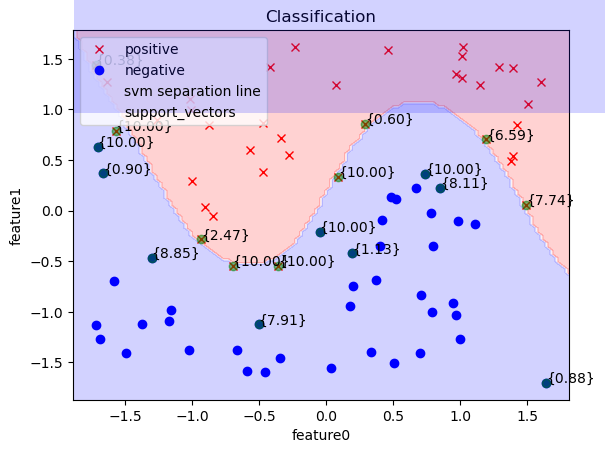

In [153]:
plt.figure()
label_1 = ((y_train == 1).T)[0]
label_minus_1 = ((y_train == -1).T)[0]
plt.plot(X_train_norm[label_1,0],X_train_norm[label_1,1], 'rx')
plt.plot(X_train_norm[label_minus_1,0],X_train_norm[label_minus_1,1], 'bo')
def plot_decision_boundary( xmin, xmax, ymin, ymax):
  xx, yy = np.meshgrid(
      np.linspace(xmin, xmax, num=100, endpoint=True), 
      np.linspace(ymin, ymax, num=100, endpoint=True))
  K = gaussian_kernel(X_train_norm, np.c_[xx.ravel(), yy.ravel()],sigma_opt)
  Z = predict(K,alpha,y_train,b)
  Z = Z.reshape(xx.shape)
  cs = plt.contourf(xx, yy, Z, alpha=0.2, cmap='bwr')
xmin, xmax, ymin, ymax = plt.axis()
plot_decision_boundary( xmin, xmax, ymin, ymax) 

for i, txt in enumerate(alpha):
    if(txt > 1e-5):
       plt.annotate('{%.2f}'%(txt), (X_train_norm[i,0], X_train_norm[i,1]))
       plt.plot(X_train_norm[i,0], X_train_norm[i,1],'go', alpha = 0.5)
       
plt.legend(['positive', 'negative','svm separation line','support_vectors']);
plt.xlabel('feature0')
plt.ylabel('feature1');
plt.title('Classification')

In [154]:
K_test = gaussian_kernel(X_train_norm,X_test_norm,sigma_opt)
y_pred_train = predict(K_train, alpha, y_train,b).T
acc_train = np.sum(y_pred_train == y_train)/len(y_train)
y_test = y_test.reshape(X_test.shape[0],1)
y_pred_test = predict(K_test, alpha, y_train,b).T
acc_test = np.sum(y_pred_test == y_test)/len(y_test)
train_loss = hinge_loss(y_pred_train, y_train)
test_loss = hinge_loss(y_pred_test, y_test)
print(acc_train)
print(acc_test)
print(train_loss)
print(test_loss)

0.95
0.85


#### Krajnja tacnost gausovog kernela je 95% na obucavajucem skupu i 85% na test skupu

### Uporedni prikaz svih modela

In [158]:
import pandas as pd
df = {"train":[0.9, 0.95, 0.95], "test":[0.85, 0.90, 0.85]}
df = pd.DataFrame.from_dict(df)
df.index = ["linear", "polynomial","gaussian"]
df

,train,test
linear,0.90,0.85
polynomial,0.95,0.90
gaussian,0.95,0.85


Vidimo da se kao najbolji pokazao polinomijalni kernel, jer daje najbolje tacnosti i najmanje se preobucio.